# Generative Adversarial Networks
This code is based on https://arxiv.org/abs/1406.2661 paper from Ian J. Goodfellow, Jean Pouget-Abadie, et all

![title](https://github.com/DSC-UI-SRIN/Introduction-to-GAN/raw/master/1%20-%20Fundamental%20of%20GANs/images/minmax.png)

In [1]:
# import All prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os

ROOT = "./MinMax-NS/"
if not os.path.exists(ROOT):
    os.mkdir(ROOT)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using {}".format(device))

using cuda


## Dataset

In [2]:
batch_size = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

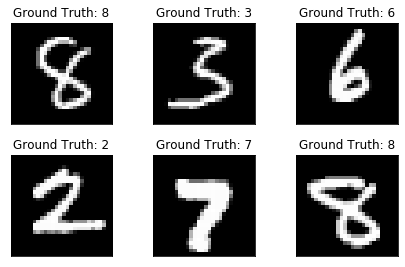

In [3]:
## Print example

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

## Build Network

![title](https://miro.medium.com/max/1600/1*M_YipQF_oC6owsU1VVrfhg.jpeg)
resource : https://medium.com/@jonathan_hui/gan-whats-generative-adversarial-networks-and-its-application-f39ed278ef09

In [4]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(d_input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, image):
        img_flat = image.view(image.size(0), -1)
        validity = self.model(img_flat)
        return validity
    
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(g_input_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, g_output_dim), 
            nn.Tanh())

    def forward(self, z):
        image = self.model(z)
        image = image.view(image.size(0), -1)
        return image

In [5]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

In [6]:
print(G, D)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
) Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)

# Train Process

In [7]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002
b1 = 0.5
b2 = 0.999
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(b1, b2))
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(b1, b2))

### Discriminator Update

![title](https://miro.medium.com/max/1720/1*4xAHMaUGXeOQnNJhzjq-4Q.jpeg)

### Generator Update

### Before : <br>
![title](https://miro.medium.com/max/1224/1*n235XEigXKL3ktL08d-CZA.jpeg) <br>
### Because Generator diminished gradient: <br>
In practice, equation 1 may not provide sufficient gradient for G to learn well.  Early in learning, when G is poor,D can reject samples with high confidence because they are clearly different fromthe training data.  In this case, log(1−D(G(z))) saturates.  Rather than training G to minimize log(1−D(G(z))) we can train G to maximize logD(G(z)). This objective function results in thesame fixed point of the dynamics of G and D but provides much stronger gradients early in learning. (GAN Paper)<br>

![title](https://miro.medium.com/max/1517/1*6So6q3dWurG8qrmwk1y3jw.jpeg) <br>

![BCEloss](https://github.com/DSC-UI-SRIN/Introduction-to-GAN/raw/master/1%20-%20Fundamental%20of%20GANs/images/BCELoss.png)

In [8]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
epochs = 200

d_losses = []
g_losses = []

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        G_optimizer.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], z_dim))))

        # Generate a batch of images
        gen_imgs = G(z)

        # Loss measures generator's ability to fool the discriminator
        # g_loss = criterion(D(gen_imgs), fake) # Normal MinMax
        g_loss = criterion(D(gen_imgs), valid) # Non Saturated

        g_loss.backward()
        G_optimizer.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        D_optimizer.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(D(real_imgs), valid)
        fake_loss = criterion(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        D_optimizer.step()
        
    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch, epochs, d_loss.item(), g_loss.item()))

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    if epoch % 5 == 0:
        save_image(
            gen_imgs.view(gen_imgs.size(0), 1, 28, 28),
            ROOT + "sample_%d.png" % epoch, nrow=5, normalize=True)

torch.save(G, ROOT + 'G.pt')
torch.save(D, ROOT + 'D.pt')

[Epoch 0/200] [D loss: 0.409358] [G loss: 0.979487]
[Epoch 1/200] [D loss: 0.531015] [G loss: 2.636233]
[Epoch 2/200] [D loss: 0.327916] [G loss: 0.994596]
[Epoch 3/200] [D loss: 0.435401] [G loss: 0.768487]
[Epoch 4/200] [D loss: 0.191651] [G loss: 2.281708]
[Epoch 5/200] [D loss: 0.372883] [G loss: 1.098316]
[Epoch 6/200] [D loss: 0.164275] [G loss: 2.104535]
[Epoch 7/200] [D loss: 0.149026] [G loss: 3.042058]
[Epoch 8/200] [D loss: 0.165205] [G loss: 2.171220]
[Epoch 9/200] [D loss: 0.164545] [G loss: 3.400653]
[Epoch 10/200] [D loss: 0.198701] [G loss: 1.615216]
[Epoch 11/200] [D loss: 0.220846] [G loss: 3.128928]
[Epoch 12/200] [D loss: 0.316144] [G loss: 1.060045]
[Epoch 13/200] [D loss: 0.307597] [G loss: 1.608868]
[Epoch 14/200] [D loss: 0.177484] [G loss: 2.017976]
[Epoch 15/200] [D loss: 0.779074] [G loss: 0.515779]
[Epoch 16/200] [D loss: 0.182962] [G loss: 3.636184]
[Epoch 17/200] [D loss: 0.231315] [G loss: 3.636222]
[Epoch 18/200] [D loss: 0.107272] [G loss: 3.263804]
[Ep

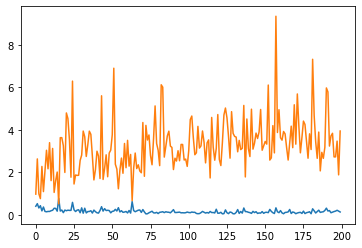

In [9]:
# Plot losses

plt.plot(d_losses, label="d_loss")
plt.plot(g_losses, label="g_loss")
plt.show()

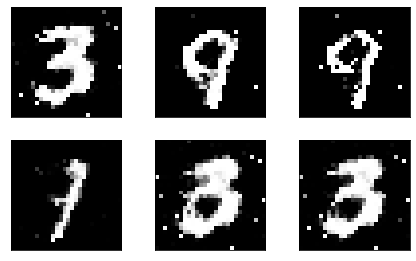

In [10]:
## Print result

gen_imgs_view = gen_imgs.view(gen_imgs.size(0), 1, 28, 28).cpu().detach().numpy()

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(gen_imgs_view[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
plt.show()